# Testing LSTM for Dog 1

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import os
from sklearn.metrics import roc_auc_score
from utils.construct_save_tensors import *

%matplotlib inline

In [2]:
# Read pregenerated tensors
# Dog 1
X = np.load("../data/lstm/Dog_1_X.npy")
Y = np.load("../data/lstm/Dog_1_Y.npy")
X_test = np.load("../data/lstm/Dog_1_test.npy")
clip_ids = np.load("../data/lstm/Dog_1_clip_ids.npy")

In [3]:
print ("Tensor shape: ", X.shape)

Tensor shape:  (3024, 200, 16)


Now, normalize by maximum and shuffle

In [4]:
# Normalize
X = X / np.max(np.abs(X), axis=1)[:,None,:]

# Shuffle to break time order 
np.random.seed(1)
shuffle = np.random.choice(np.arange(len(Y)), size=len(Y), replace=False)
X = X[shuffle]
Y = Y[shuffle]
clip_ids = clip_ids[shuffle]

### Tensorflow

In [5]:
import tensorflow as tf 
from sklearn.metrics import roc_auc_score 

Hyperparameters:

In [6]:
## Example hyperparameters
lstm_size = 32         # Number of neurons in each LSTM cell
lstm_layers = 2        # Number of LSTM layers
batch_size = 200       # Obs. per batch
seq_len = 200          # Sequence length
learning_rate = 0.0001 # Learning rate
epochs = 500           # Number of epochs

# Fixed param, number of channels
n_channels = 16

Initiate graph and add placeholders

In [7]:
# Initiate graph object
graph = tf.Graph() 

# Construct placeholders
# inputs_ : (n_batch, seq_len, n_channels)
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, None, n_channels], name='inputs')
    labels_ = tf.placeholder(tf.float32, [None,1], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM layers: 

In [8]:
# Construct input to LSTM layers
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # swap seq_len and batch_size
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # reshape to rank 2

    # Linear activation
    lstm_in = tf.layers.dense(lstm_in, lstm_size, tf.nn.relu)

    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)

Construct LSTM cells

In [9]:
with graph.as_default():
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    #initial_state =  cell.zero_state(batch_size, tf.float32)


Define forward pass, cost function and optimizer

In [11]:
# Forward pass and outputs
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32) # initial_state = initial_state
    
    # We only need the last output tensor to pass into predictions
    logits = tf.layers.dense(outputs[-1], 1)
    predictions = tf.nn.sigmoid(logits)

    # Cost function
    #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels_, logits = logits))
    #cost = tf.losses.mean_squared_error(labels = labels_, predictions = predictions)   
    #cost = tf.losses.log_loss(labels = labels_, predictions=predictions)
    cost = tf.losses.sigmoid_cross_entropy(multi_class_labels = labels_, logits = logits)

    # Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)

Batching iterator

In [12]:
## Construct a generator object to split the data into batches
def get_batches(X, y, batch_size = 100):
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size] # Cut the end to have an integert multiple of batch_size

    # Loop over bacthes and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size][:,None]

Split into training and validaton sets

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, stratify=Y, test_size = 0.2, random_state = 1234)

In [14]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints


Train the LSTM:

In [15]:
val_auc = []
with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        #state = sess.run(initial_state)

        # Loop over batches
        for ii, (x, y) in enumerate(get_batches(X_train, Y_train, batch_size), 1):
            
            # Feed dictionary
            feed = {inputs_: x,
                    labels_: y.astype(np.float32),
                    keep_prob_: 0.5,
                    learning_rate_: learning_rate}
                    #initial_state: state}

            # Run the graph to get loss
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {}".format(loss))
            
            # Compute validation at every 25 iterations
            if iteration%25==0:

                # Get initial state for the validation set
                #val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                # Compute score on validation set
                feed={inputs_:X_valid,
                      labels_:Y_valid[:,None].astype(np.float32),
                      keep_prob_: 1}
                preds = sess.run(predictions, feed_dict=feed)
                auc = roc_auc_score(Y_valid[:,None].astype(np.float32), preds)
                val_auc.append(auc)
                print("Validation AUC: {}".format(auc))
                
            iteration += 1

                
    saver.save(sess, "checkpoints/eeg.ckpt")

Epoch: 0/500 Iteration: 5 Train loss: 0.653358519077301
Epoch: 0/500 Iteration: 10 Train loss: 0.6409740447998047
Epoch: 1/500 Iteration: 15 Train loss: 0.6335064172744751
Epoch: 1/500 Iteration: 20 Train loss: 0.6131297945976257
Epoch: 2/500 Iteration: 25 Train loss: 0.607958197593689
Validation AUC: 0.5434626436781609
Epoch: 2/500 Iteration: 30 Train loss: 0.592004656791687
Epoch: 2/500 Iteration: 35 Train loss: 0.586287796497345
Epoch: 3/500 Iteration: 40 Train loss: 0.5770770907402039
Epoch: 3/500 Iteration: 45 Train loss: 0.5623218417167664
Epoch: 4/500 Iteration: 50 Train loss: 0.5459467768669128
Validation AUC: 0.5590277777777778
Epoch: 4/500 Iteration: 55 Train loss: 0.520070493221283
Epoch: 4/500 Iteration: 60 Train loss: 0.5159249901771545
Epoch: 5/500 Iteration: 65 Train loss: 0.49209892749786377
Epoch: 5/500 Iteration: 70 Train loss: 0.4607657194137573
Epoch: 6/500 Iteration: 75 Train loss: 0.45767611265182495
Validation AUC: 0.5600454980842912
Epoch: 6/500 Iteration: 80 Tr

KeyboardInterrupt: 

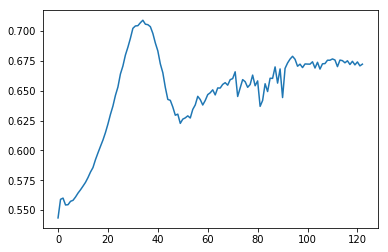

In [17]:
plt.plot(val_auc)